In [8]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
import zipfile

zip_path = r"D:\Study\Image Recognition project\DATA\Classification_dataset_v3.zip"
extract_path = r"D:\Study\Image Recognition project\DATA\Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [9]:
image_dir = r'D:\Study\Image Recognition project\DATA\Dataset\Classification_dataset_v3\images\train'
for label, class_dir in enumerate(os.listdir(image_dir)):
    print(label, class_dir)

0 Cat
1 Dog
2 person


In [10]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_name={}
        
        #index is assigned to each class as pytorch model predict index
        for label, class_dir in enumerate(os.listdir(image_dir)):
            self.class_name[label]=class_dir
            class_path = os.path.join(image_dir, class_dir)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(label)
    #gets total number of images in the dataset
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [11]:
#ToTensor() method converts a PIL Image or numpy.ndarray to tensor ie converts [0,255] range to [0,1]
#Resize() method resizes the image to the given size
#Normalize() method normalizes a tensor image with mean and standard deviation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])]
)

#normalize_pixel_value = (pixel_value - mean) / std

In [12]:
train_image_dir = r'DATA\Dataset\Classification_dataset_v3\images\train'
test_image_dir = r'DATA\Dataset\Classification_dataset_v3\images\test'

train_image_dataset = ImageDataset(image_dir=train_image_dir, transform=transform)
test_image_dataset = ImageDataset(image_dir=test_image_dir, transform=transform)

In [13]:
train_image_loader = DataLoader(train_image_dataset, batch_size=32, shuffle=True)
test_image_loader = DataLoader(test_image_dataset, batch_size=32, shuffle=False)

In [14]:
for images,labels in train_image_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
print(train_image_dataset.class_name)
print(test_image_dataset.class_name)

{0: 'Cat', 1: 'Dog', 2: 'person'}
{0: 'Cat', 1: 'Dog', 2: 'person'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 128, 128]) torch.Size([32])
(3, 128, 128)
person
(128, 128, 3)
2


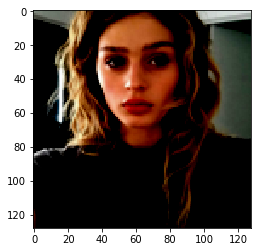

In [17]:
for images, labels in train_image_loader:
    print(images.shape, labels.shape)
    img=images[0].numpy()
    print(img.shape)
    label = labels[0].item()
    print(train_image_dataset.class_name[label])
    img = np.transpose(img, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    print(img.shape)
    print(label)
    plt.imshow(img,vmin=0, vmax=255)
    break

Custom CNN Architecture

consists of convolution,stride,padding,max pool, batch normalization, activation function, FC layers

In [21]:
import torch.nn as nn
import torch.optim as optim

In [22]:
class CustomCnnModel(nn.Module):
    def __init__(self,input_dim,num_classes):
        super(CustomCnnModel,self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(
            #C1
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            #128x128x3 --> 3x3x3x32 -->w x h x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #C2
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #C3
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #C4
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self._to_linear = None
        self._get_conv_output(self.input_dim)

        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear,512),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,self.num_classes),
        )
        #256 x 12 x 12

    def _get_conv_output(self,input_dim=128):
        with torch.no_grad():
            dummy_input = torch.zeros(1,3,input_dim,input_dim)
            output = self.conv_layers(dummy_input)
            self._to_linear = output.view(1,-1).size(1)

    def forward(self,x):
        x=self.conv_layers(x)
        x=x.view(x.size(0),-1)
        x=self.fc_layers(x)
        return x

In [23]:
#Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCnnModel(input_dim=128,num_classes=3).to(device)

In [22]:
print(model)

CustomCnnModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

100 epoch

1000 
10 batch size
100

1 epoch --> 100 iteration
#2 epoch -->100 iteration

In [26]:
len(train_image_loader)

95

In [28]:
#training loop
epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss=0.0
    for images,labels in train_image_loader:
        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)

        #[x,3,128,128]
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_image_loader)}")

c:\Users\ammus\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
c:\Users\ammus\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
c:\Users\ammus\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
c:\Users\ammus\anaconda3\envs\python-cvcourse\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
c:\Users\ammus\

Epoch 1/2, Loss: 0.6449249515407964
Epoch 2/2, Loss: 0.5564210728595131


In [1]:
torch.save(model.state_dict(),"saved/cnn_model.pth")

NameError: name 'torch' is not defined

In [31]:
for images, labels in test_image_loader:
    print(labels.shape)
    break

torch.Size([32])


In [32]:
# Evaluate model

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images,labels in test_image_loader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test accuracy is: {100* correct / total:.2f}%")

Test accuracy is: 74.00%


In [2]:
import cv2

In [18]:
class ImageClassifier:
    def __init__(self, model_path, class_names, input_dim=128, device=None):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = CustomCnnModel(input_dim=input_dim, num_classes=len(class_names)).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        self.class_names = class_names
        self.transform = transforms.Compose([
            transforms.Resize((input_dim, input_dim)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def predict(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)  # Add batch dimension
        with torch.no_grad():
            outputs = self.model(image)
            _, predicted = torch.max(outputs, 1)
            predicted_class = self.class_names[predicted.item()]
        label = self.class_names[predicted.item()]

        img = cv2.imread(image_path)
        cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imwrite("output_image.jpg",img)

        return label

In [25]:
classifier = ImageClassifier("cnn_model.pth", train_image_dataset.class_name)
label = classifier.predict(r"DATA\Dataset\Classification_dataset_v3\images\train\Dog\dog_0000.jpg")
print(f"Predicted class: {label}")

Predicted class: Cat
